In [1]:
import astra
import copy
import tomophantom
import numpy as np
import os
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.ndimage import shift, median_filter, convolve, gaussian_filter
from skimage.transform import rescale
from tomophantom import TomoP2D

In [2]:
%load_ext watermark

%watermark -v -m -p astra,copy,tomophantom,numpy,os,seaborn,ipywidgets,matplotlib,mpl_toolkits,scipy,skimage

Python implementation: CPython
Python version       : 3.7.7
IPython version      : 7.22.0

astra       : 1.9.9.dev
copy        : unknown
tomophantom : 1.2
numpy       : 1.21.1
os          : unknown
seaborn     : 0.11.0
ipywidgets  : 7.6.3
matplotlib  : 3.4.3
mpl_toolkits: unknown
scipy       : 1.6.2
skimage     : 0.18.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 4.4.0-21390-Microsoft
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [3]:
model = 8 # select a model number from the library
N_size = 512 # set dimension of the phantom

path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, 'Phantom2DLibrary.dat')
volTrue = TomoP2D.Model(model, N_size, path_library2D)

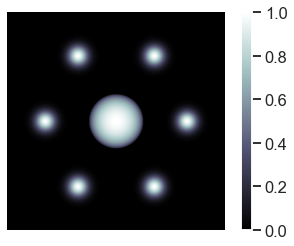

In [4]:
with plt.style.context('seaborn-dark'):
    sns.set_context('talk')
    
    plt.imshow(volTrue, cmap='bone')
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [5]:
# Number of lines-of-sight
angles = np.deg2rad([0, 120, 240])
numLOS = len(angles)

# Number of detectors per line-of-sight
numDet = 512

# Setup ASTRA geometry
proj_geom = astra.create_proj_geom('parallel', 1, numDet, angles)
vol_geom = astra.create_vol_geom(N_size, N_size) 
proj_id = astra.create_projector('line', proj_geom, vol_geom)
matrix_id = astra.projector.matrix(proj_id)

# Create sinograms
_, trueProjData = astra.create_sino(volTrue, proj_id)

# Volume size
volSize = volTrue.shape

# Setup the projection matrix as an opTomo object
W = astra.optomo.OpTomo(proj_id)

# Simulate Noise
https://stackoverflow.com/a/53688043/16310149

In [6]:
def addNoise(x_volts, targer_snr_db):
    """Adding noise using target SNR"""
    x_watts = x_volts**2
    
    # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generate an sample of white noise
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
    # Noise up the original signal
    y_volts = x_volts + noise_volts
    
    return y_volts
    
    
# Initialize projData variable
noisyProjData = np.zeros_like(trueProjData)

# Set a target SNR
target_snr_db = 20

# Add noise to each view
for i in range(numLOS):
    noisyProjData[i,:] = addNoise(trueProjData[i,:], target_snr_db)
    
# Recover some of the signal through a median filter
projData = median_filter(noisyProjData, 3)

In [7]:
def plotSino(noisyProjData, projData, ind=0):
    with plt.style.context('seaborn-dark'):
        sns.set_context('talk')
        
        plt.plot(noisyProjData[ind], label='Noisy')
        plt.plot(projData[ind], label='Smoothed')
        plt.legend()
        plt.title(f'View {ind+1}')
        plt.ylim([-10, 150])
        plt.xlabel('Pixel (px)')
        plt.ylabel('Intensity (a.u.)')
    
    
interactive_plot = interactive(
                               plotSino, 
                               noisyProjData=fixed(noisyProjData), 
                               projData=fixed(projData), 
                               ind=(0, projData.shape[0]-1))
interactive_plot

interactive(children=(IntSlider(value=0, description='ind', max=2), Output()), _dom_classes=('widget-interact'…

# Algorithms

In [8]:
def MLOS(W, proj, constraint, numLOS):
    """
    Run through line-of-sight initialization routine.
    """
    # Volume shape
    volShape = W.vshape

    # Define type of projections to use
    # 'Ones' projection checks all the pixels on the camera
    if constraint == 'ones':
        proj_binned = np.ones_like(proj)
    # 'Proj' projection checks only the populated pixels on the camera
    # This technically changes for every time step in temporally resolved
    # measurements. Consider averaging all the images before using this
    # for a more inclusive answer.
    elif constraint == 'proj':
        proj_binned = (proj > 0).astype(int)

    # Number of projections
    numViews = np.shape(proj)[0]

    # Initialize MLOS volume
    v_views = np.zeros([numViews] + list(volShape))

    for i in range(numViews):
        proj_view = np.zeros_like(proj_binned)
        proj_view[i,:] = proj_binned[i,:]
        v_views[i,:] = W.BP(proj_view)

    v_views = v_views > 0
    v = np.sum(v_views, axis=0)

    # Apply line-of-sight constraint
    v = v >= numLOS

    return v.astype('float32')


def MLEM(W, v, proj, reproj, mu, weightsV):
    """
    Run through MLEM algorithm for tomographic reconstruction.
    """
    # Remove invalid values
    reproj[np.isnan(reproj)] = 0
    reproj[np.isinf(reproj)] = 0

    ratio = np.divide(proj, reproj,
                      out=np.zeros_like(proj),
                      where=reproj!=0)
    cf = W.BP(mu * ratio) * weightsV

    # Update volume
    v *= cf

    return v

In [9]:
# Weights for the volume correction
onesBP = W.BP(np.ones_like(projData))
weightsV = np.divide(np.ones_like(onesBP), onesBP,
                     out=np.zeros_like(onesBP),
                     where=onesBP!=0)

# Weights for the projDataection correction
onesFP = W.FP(np.ones_like(volTrue))
weightsP = np.divide(np.ones_like(onesFP), onesFP,
                     out=np.zeros_like(onesFP),
                     where=onesFP!=0)

In [10]:
mu = 1
iters = 100
smoothStrength = 3
volInit = MLOS(W, projData, 'ones', numLOS)
volIter = copy.deepcopy(volInit)
convergence = [None] * iters

for i in range(iters):
    reprojData = W.FP(volIter)
    norm1 = np.linalg.norm(reprojData, axis=1)
    volIter = MLEM(W, volIter, projData, reprojData, mu, weightsV)
    volIter = median_filter(volIter, smoothStrength)
    reprojData = W.FP(volIter)
    norm2 = np.linalg.norm(reprojData, axis=1)
    
    convergence[i] = abs(norm2 - norm1) / norm2
    

volRecon = copy.deepcopy(volIter)
reprojData = W.FP(volRecon)
convergence = np.array(convergence)

# Visualization

## Convergence

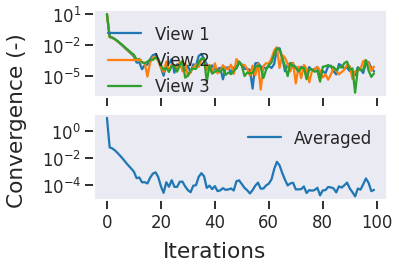

In [11]:
with plt.style.context('seaborn-dark'):
    sns.set_context('talk')
    fig, ax = plt.subplots(2, 1)
    plt.subplots_adjust(left=0.22, bottom=0.22)
    
    for i in range(numLOS):
        ax[0].plot(convergence[:,i], label=f'View {i+1}')
        
    ax[0].set_xticklabels([])
    ax[1].plot(np.mean(convergence, axis=1), label='Averaged')
        
    for axx in ax:
        axx.legend()
        axx.set_yscale('log')
        
    fig.supxlabel('Iterations')
    fig.supylabel('Convergence (-)')

## Volume Comparison

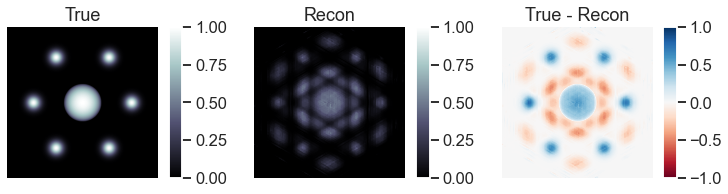

In [12]:
with plt.style.context('seaborn-dark'):
    sns.set_context('talk')
    fig = plt.figure(figsize=(12,16))

    grid = ImageGrid(fig, 111,
                    nrows_ncols=(1,3),
                    axes_pad=1,
                    share_all=True,
                    cbar_location='right',
                    cbar_mode='each',
                    direction = 'row',
                    cbar_size="9%",
                    cbar_pad=0.15)

    true = grid[0].imshow(volTrue, cmap='bone', vmin=0, vmax=1)
    recon = grid[1].imshow(volRecon, cmap='bone', vmin=0, vmax=1)
    delta = grid[2].imshow(volTrue - volRecon, cmap='RdBu', vmin=-1, vmax=1)

    # Set colorbar
    grid[0].cax.colorbar(true)
    grid[1].cax.colorbar(recon)
    grid[2].cax.colorbar(delta)

    # Labels
    grid[0].set_title('True')
    grid[1].set_title('Recon')
    grid[2].set_title('True - Recon')
    
    for ax in grid:
        ax.axis('off')
        
    plt.show()

## Projection Comparison

In [13]:
def compareSino(projData, reprojData, ind=0):
    with plt.style.context('seaborn-dark'):
        sns.set_context('talk')
        fig, ax = plt.subplots(1, 1)

        ax.plot(projData[ind], label='Proj')
        ax.plot(reprojData[ind], linestyle='--', alpha=0.9, label='Reproj')
        ax.plot(projData[ind]-reprojData[ind], linewidth=0.8, linestyle='-', color='k', label='Proj-Reproj')
        ax.legend(loc='best', fontsize='xx-small')
        ax.set_title(f'View {ind+1}')
        ax.set_ylim([-10, 150])
        ax.set_xlabel('Pixel (px)')
        ax.set_ylabel('Intensity (a.u.)')
    
    
interactive_plot = interactive(
                               compareSino, 
                               projData=fixed(projData), 
                               reprojData=fixed(reprojData), 
                               ind=(0, projData.shape[0]-1))
interactive_plot

interactive(children=(IntSlider(value=0, description='ind', max=2), Output()), _dom_classes=('widget-interact'…